The following example notebook implements standard diffusion
with a simple CNN model to generate realistic MNIST digits.

This is a modified implementation of `minDiffusion`
which implements [DDPM](https://arxiv.org/abs/2006.11239).

To run this example notebook,
install requirements as in `requirements.txt` (for example, `pip install -r requirements.txt`).
You may also wish to follow system-dependent PyTorch instructions
[here](https://pytorch.org/) to install accelerated
versions of PyTorch, but note they are not needed
(I am testing this on my laptop).

If you do use accelerated hardware, make sure that your code
is still compatible with CPU-only installs.

First, let's create a folder to store example images:

In [1]:
!mkdir -p contents

In [2]:
from typing import Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
from accelerate import Accelerator
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from icecream import ic
import matplotlib.pyplot as plt

/Users/vishaljain/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The following function creates a DDPM training schedule for use when evaluating
and training the diffusion model:

In [3]:
def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """Returns pre-computed schedules for DDPM sampling with a linear noise schedule."""
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    alpha_t = torch.exp(torch.cumsum(torch.log(1 - beta_t), dim=0))  # Cumprod in log-space (better precision)
    ic(beta_t)
    return {"beta_t": beta_t, "alpha_t": alpha_t}


Next, we create a simple 2D convolutional neural network. This network
is essentially going to try to estimate the diffusion process --- we
can then use this network to generate realistic images.

First, we create a single CNN block which we will stack to create the
full network. We use `LayerNorm` for stable training and no batch dependence.

In [4]:
class CNNBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        expected_shape,
        act=nn.GELU,
        kernel_size=7,
    ):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.LayerNorm(expected_shape),
            act()
        )

    def forward(self, x):
        return self.net(x)

We then create the full CNN model, which is a stack of these blocks
according to the `n_hidden` tuple, which specifies the number of
channels at each hidden layer.

In [5]:
class CNN(nn.Module):
    def __init__(
        self,
        in_channels,
        expected_shape=(28, 28),
        n_hidden=(64, 128, 64),
        kernel_size=7,
        last_kernel_size=3,
        time_embeddings=16,
        act=nn.GELU,
    ) -> None:
        super().__init__()
        last = in_channels

        self.blocks = nn.ModuleList()
        for hidden in n_hidden:
            self.blocks.append(
                CNNBlock(
                    last,
                    hidden,
                    expected_shape=expected_shape,
                    kernel_size=kernel_size,
                    act=act,
                )
            )
            last = hidden

        # The final layer, we use a regular Conv2d to get the
        # correct scale and shape (and avoid applying the activation)
        self.blocks.append(
            nn.Conv2d(
                last,
                in_channels,
                last_kernel_size,
                padding=last_kernel_size // 2,
            )
        )

        ## This part is literally just to put the single scalar "t" into the CNN
        ## in a nice, high-dimensional way:
        self.time_embed = nn.Sequential(
            nn.Linear(time_embeddings * 2, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, n_hidden[0]),
        )
        frequencies = torch.tensor(
            [0] + [2 * np.pi * 1.5**i for i in range(time_embeddings - 1)]
        )
        self.register_buffer("frequencies", frequencies)

    def time_encoding(self, t: torch.Tensor) -> torch.Tensor:
        phases = torch.concat(
            (
                torch.sin(t[:, None] * self.frequencies[None, :]),
                torch.cos(t[:, None] * self.frequencies[None, :]) - 1,
            ),
            dim=1,
        )

        return self.time_embed(phases)[:, :, None, None]

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Shapes of input:
        #    x: (batch, chan, height, width)
        #    t: (batch,)

        embed = self.blocks[0](x)
        # ^ (batch, n_hidden[0], height, width)

        # Add information about time along the diffusion process
        #  (Providing this information by superimposing in latent space)
        embed += self.time_encoding(t)
        #         ^ (batch, n_hidden[0], 1, 1) - thus, broadcasting
        #           to the entire spatial domain

        for block in self.blocks[1:]:
            embed = block(embed)
        
        return embed

Next, we define the actual diffusion model, which specifies the training
schedule, takes an arbitrary model for estimating the
diffusion process (such as the CNN above),
and computes the corresponding loss (as well as generating samples).

In [6]:
class DDPM(nn.Module):
    def __init__(
        self,
        gt,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super().__init__()

        self.gt = gt

        noise_schedule = ddpm_schedules(betas[0], betas[1], n_T)

        # `register_buffer` will track these tensors for device placement, but
        # not store them as model parameters. This is useful for constants.
        self.register_buffer("beta_t", noise_schedule["beta_t"])
        self.beta_t  # Exists! Set by register_buffer
        self.register_buffer("alpha_t", noise_schedule["alpha_t"])
        self.alpha_t
        ic(self.beta_t)
        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Algorithm 18.1 in Prince"""
        ic(x.shape)
        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)
        alpha_t = self.alpha_t[t, None, None, None]  # Get right shape for broadcasting
        z_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * eps
        ic(z_t.shape)
        # This is the z_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this z_t. Loss is what we return.

        return self.criterion(eps, self.gt(z_t, t / self.n_T))
    
    def degrade(self, x, t, device):
        eps = torch.randn_like(x) # eps ~ N(0, 1)
        alpha_t = self.alpha_t[t, None, None, None]  # Get right shape for broadcasting
        z_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * eps
        ic(self.beta_t)
        return z_t
    
    def sample(self, n_sample: int, size, device) -> torch.Tensor:
        """Algorithm 18.2 in Prince"""

        _one = torch.ones(n_sample, device=device)
        z_t = torch.randn(n_sample, *size, device=device)
        for i in range(self.n_T, 0, -1):
            alpha_t = self.alpha_t[i]
            beta_t = self.beta_t[i]

            # First line of loop:
            z_t -= (beta_t / torch.sqrt(1 - alpha_t)) * self.gt(z_t, (i/self.n_T) * _one)
            z_t /= torch.sqrt(1 - beta_t)

            if i > 1:
                # Last line of loop:
                z_t += torch.sqrt(beta_t) * torch.randn_like(z_t)
            # (We don't add noise at the final step - i.e., the last line of the algorithm)
        return z_t
    
    def restore(self, z_t: torch.Tensor, return_intermediary_ts, device) -> torch.Tensor:
        """Algorithm 18.2 in Prince"""
        n_sample = z_t.shape[0]
        _one = torch.ones(n_sample, device=device)
        intermediary_z_t = torch.zeros((len(return_intermediary_ts)*n_sample, *z_t.shape[1:]), device=device)
        for i in range(self.n_T, 0, -1):
            alpha_t = self.alpha_t[i]
            beta_t = self.beta_t[i]

            # First line of loop:
            z_t -= (beta_t / torch.sqrt(1 - alpha_t)) * self.gt(z_t, (i/self.n_T) * _one)
            z_t /= torch.sqrt(1 - beta_t)

            if i > 1:
                # Last line of loop:
                z_t += torch.sqrt(beta_t) * torch.randn_like(z_t)
            
            for i in return_intermediary_ts:
                intermediary_z_t[(i-1)*n_sample:i*n_sample] = z_t

        return z_t, intermediary_z_t
    
    def cond_sample(self, x: torch.Tensor, visualise_timesteps, device) -> torch.Tensor:
        """Algorithm 18.3 in Prince"""
        batch_size = x.shape[0]
        # multiply by 2 because we want to visualise the degradation and the reconstruction.
        out_t = torch.zeros((2*(len(visualise_timesteps)*batch_size)+1, *x.shape[1:]), device=device)
        out_t[:batch_size] = x
        for idx, t in enumerate(visualise_timesteps, start=1):
            # Generate the degraded version of the image
            z_t = self.degrade(x, t, device)
            _ = z_t.squeeze().detach().cpu().numpy()
            print(t)
            # plt.imshow(_)
            # plt.show()
            out_t[idx*batch_size:(idx+1)*batch_size] = z_t
        
        # Reconstruct the image
        # ic(x.shape)
        # z_t = self.degrade(x, self.n_T, device)
        # _, x_t = self.restore(z_t, visualise_timesteps, device)
        # out_t[len(visualise_timesteps)*batch_size:] = x_t
        return out_t

We will run this on MNIST. We perform some basic preprocessing, and set up the data loader:

In [7]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)

We create our model with a given choice of hidden layers and activation function. We also choose a learning rate.

In [8]:
gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=(16, 32, 32, 16), act=nn.GELU)
# For testing: (16, 32, 32, 16)
# For more capacity (for example): (64, 128, 256, 128, 64)
ddpm = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)
optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

ic| beta_t: tensor([1.0000e-04, 1.1990e-04, 1.3980e-04,  ..., 1.9960e-02, 1.9980e-02,
                    2.0000e-02])
ic| self.beta_t: tensor([1.0000e-04, 1.1990e-04, 1.3980e-04,  ..., 1.9960e-02, 1.9980e-02,
                         2.0000e-02])


We could set up a GPU if we have one, which is done below.

Here, we use HuggingFace's `accelerate` library, which abstracts away all the `.to(device)` calls for us.
This lets us focus on the model itself rather than data movement.
It also does a few other tricks to speed up calculations.

PyTorch Lightning, which we discussed during the course, is another option that also handles a lot more, but is a bit heavyweight.
`accelerate` is a simpler option closer to raw PyTorch.
However, if you prefer, you could choose to use Lightning for the coursework!

In [9]:
accelerator = Accelerator()

# We wrap our model, optimizer, and dataloaders with `accelerator.prepare`,
# which lets HuggingFace's Accelerate handle the device placement and gradient accumulation.
ddpm, optim, dataloader = accelerator.prepare(ddpm, optim, dataloader)

First, let's just make sure this works:

In [10]:
for x, _ in dataloader:
    break

with torch.no_grad():
    ddpm(x)

ic| x.shape: torch.Size([128, 1, 28, 28])
ic| z_t.shape: torch.Size([128, 1, 28, 28])


Now, let's train it. You can exit early by interrupting the kernel. Images
are saved to the `contents` folder.

In [11]:
n_epoch = 100
losses = []

for i in range(n_epoch):
    ddpm.train()

    pbar = tqdm(dataloader)  # Wrap our loop with a visual progress bar
    for x, _ in pbar:
        optim.zero_grad()

        loss = ddpm(x)

        loss.backward()
        # ^Technically should be `accelerator.backward(loss)` but not necessary for local training

        losses.append(loss.item())
        avg_loss = np.average(losses[min(len(losses)-100, 0):])
        pbar.set_description(f"loss: {avg_loss:.3g}")  # Show running average of loss in progress bar

        optim.step()
        break

    ddpm.eval()
    with torch.no_grad():
        xh = ddpm.sample(16, (1, 28, 28), accelerator.device)  # Can get device explicitly with `accelerator.device`
        grid = make_grid(xh, nrow=4)
        ic(xh.shape)
        ic(grid.shape)

        # Save samples to `./contents` directory
        save_image(grid, f"./contents/ddpm_sample_{i:04d}.png")

        # save model
        torch.save(ddpm.state_dict(), f"./ddpm_mnist.pth")
        break


  0%|          | 0/468 [00:00<?, ?it/s]ic| x.shape: torch.Size([128, 1, 28, 28])
ic| z_t.shape: torch.Size([128, 1, 28, 28])
loss: 1.11:   0%|          | 0/468 [00:02<?, ?it/s]
ic| xh.shape: torch.Size([16, 1, 28, 28])
ic| grid.shape: torch.Size([3, 122, 122])


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_grid(images, nrow=8, padding=2, normalize=False):
    """
    Plot a grid of images using matplotlib.
    
    Parameters:
    - images: Tensor of images (N, C, H, W).
    - nrow: Number of images in each row.
    - padding: Space between images.
    - normalize: Normalize images to [0, 1].
    """
    if normalize:
        # Normalize to [0, 1]
        images = (images - images.min()) / (images.max() - images.min())
    
    # Number of images, channels, height, width
    N, C, H, W = images.shape
    ncol = int(np.ceil(N / nrow))
    
    # detach images
    images = images.detach().cpu().numpy()
    # Create an empty array to hold the grid
    grid = np.ones((C, H * ncol + padding * (ncol - 1), W * nrow + padding * (nrow - 1))) * np.min(images)
    
    # Populate the grid
    for index, image in enumerate(images):
        row = index // nrow
        col = index % nrow
        if C == 1:  # For grayscale, remove the channel dimension
            image = image.squeeze(0)
        grid[:, row * (H + padding):(row * (H + padding)) + H, col * (W + padding):(col * (W + padding)) + W] = image

    # If the images are grayscale, we should only have one channel
    if C == 1:
        grid = grid.squeeze(0)
    
    plt.figure(figsize=(nrow, ncol))
    plt.imshow(grid, cmap='gray' if C == 1 else None)
    plt.axis('off')
    plt.savefig(f"./contents/test.png", dpi=300)
    plt.show()

# Example usage:
# Assuming `images_tensor` is your tensor of shape (N, C, H, W)
# plot_grid(images_tensor, nrow=8, normalize=True)


ic| self.beta_t: tensor([0.0001, 0.0001, 0.0001,  ..., 0.0200, 0.0200, 0.0200], device='mps:0')
ic| self.beta_t: tensor([0.0001, 0.0001, 0.0001,  ..., 0.0200, 0.0200, 0.0200], device='mps:0')
ic| self.beta_t: tensor([0.0001, 0.0001, 0.0001,  ..., 0.0200, 0.0200, 0.0200], device='mps:0')


0
1
2


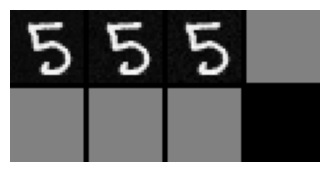

In [13]:
x_t = x[0][None,:,:,:]
out_t = ddpm.cond_sample(x_t, [0,1,2], accelerator.device)
plot_grid(out_t, 4)